# RoBERTa

In [1]:
import sys
sys.path.append('..')

import import_ipynb
from data_preparation import Preprocessing

importing Jupyter notebook from /Users/alessia/UniProjects/HLT/src/classifiers/../data_preparation/Preprocessing.ipynb


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Transformers library for BERT
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix
from transformers import RobertaModel, RobertaTokenizer

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

In [3]:
df = pd.read_csv('../../data/updated_tweets.csv')

### Normalize

In [4]:
def normalize_tweet_BERT(tweet):
    tweet = Preprocessing.remove_links_mentions(tweet)
    tweet = tweet.lower()
    tweet = Preprocessing.remove_hashtag(tweet)
    tweet = Preprocessing.remove_special_characters(tweet)
 
    tweet = Preprocessing.remove_spaces(tweet)
    tweet = Preprocessing.remove_textual_emojis(tweet)
    tweet = Preprocessing.remove_not_ASCII(tweet)

    return tweet

In [5]:
df['tweet_text'] = df['tweet_text'].apply(normalize_tweet_BERT)
df = Preprocessing.clean_normalized_df(df)

In [6]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion             7963
age                  7949
ethnicity            7893
not_cyberbullying    7711
gender               7665
Name: count, dtype: int64

In seguito a questo risultato, confermiamo che i dati sono bilanciati

### Labels encoding

In [7]:
possible_labels = df.cyberbullying_type.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'not_cyberbullying': 0, 'gender': 1, 'religion': 2, 'age': 3, 'ethnicity': 4}

Sostituiamo nel dataset

In [8]:
df['label'] = df.cyberbullying_type.replace(label_dict)
df.head(3)

,tweet_text,cyberbullying_type,label
0,"in other words katandandre, your food was crap...",not_cyberbullying,0
1,why is aussietv so white?,not_cyberbullying,0
2,a classy whore? or more red velvet cupcakes?,not_cyberbullying,0


### Dataset split

In [9]:
X = df['tweet_text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

### RoBERTa Tokenization

In [10]:
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name, truncation=True, do_lower_case=True)

In [11]:
def calcola_media_lunghezza_tweet(tweets):
    """
    Calcola la lunghezza media dei tweet in una lista.

    Args:
    tweets (list of str): Lista di tweet.

    Returns:
    float: Lunghezza media dei tweet.
    """
    if not tweets:
        return 0.0

    lunghezze = [len(tweet) for tweet in tweets]
    media_lunghezza = sum(lunghezze) / len(lunghezze)
    return media_lunghezza

tweets = df['tweet_text'].tolist()
media_lunghezza = calcola_media_lunghezza_tweet(tweets)
print(f"La lunghezza media dei tweet è: {media_lunghezza}")


La lunghezza media dei tweet è: 135.88479109772595


In [12]:
MAX_LEN = 150

In [13]:
#pip install keras

In [14]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [15]:
from keras.preprocessing.sequence import pad_sequences


'''def encode_data(data_type):
    encoded_data = tokenizer.batch_encode_plus(
        df[df.data_type == data_type].tweet_text.values, 
        add_special_tokens = True,         # Add [CLS] and [SEP] special tokens
        return_attention_mask = True,      # it will return the attention mask according to the specific tokenizer defined by the max_length attribute
        max_length = MAX_LEN,
        padding = 'max_length', 
        truncation = True,
        return_tensors = 'pt'              # return pytorch, i tensori servono a rappresentare e manipolare dati multidimensionali in modo efficiente
    )
    return encoded_data
'''

def roberta_tokenizer(data, max_len=MAX_LEN):
    print(MAX_LEN)
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add [CLS] and [SEP] special tokens
            max_length=max_len,             # Choose max length to truncate/pad
            padding = 'max_length', 
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", value=0, truncating="post", padding="post")
    attention_masks = pad_sequences(attention_masks, maxlen=max_len, dtype="long", value=0, truncating="post", padding="post")

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
maxx_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', maxx_len)

Max length:  415


Tokenize the train, validation and test tweets using the custom define tokenizer.

In [16]:
train_inputs, train_masks = roberta_tokenizer(X_train)
val_inputs, val_masks = roberta_tokenizer(X_valid)
test_inputs, test_masks = roberta_tokenizer(X_test)

150
150
150


In [17]:
#print(train_inputs[1])
#train_masks[1]

Since we are using the BERT model built on PyTorch, we need to convert the arrays to pytorch tensors and create *dataloaders* for the data.


In [18]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)
train_labels

tensor([1, 3, 3,  ..., 1, 1, 2])

#### Dataloaders

In [19]:
batch_size = 32
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

#### ROBERTA Modeling

In [20]:
#La classe Roberta_Classifier eredita da nn.Module e rappresenta 
# il modello di classificazione basato su RoBERTa

class Roberta_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Roberta_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 6

        # Instantiate BERT model (pre-trained)
        self.roberta = RobertaModel.from_pretrained("roberta-base")

        # Instantiate the classifier (a fully connected layer followed by a ReLU activation and another fully connected layer)
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),   #Un classificatore sequenziale con un livello lineare, dropout, attivazione LeakyReLU, e un altro livello lineare
            nn.Dropout(0.2),    #definisce un livello di dropout con una probabilità di 0.3 per prevenire l'overfitting
            nn.LeakyReLU(),
            nn.Linear(n_hidden, n_output)
        )

        # Freeze the BERT model weights if freeze_bert is True (useful for feature extraction without fine-tuning)
        if freeze_bert:
            for param in self.roberta.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input data (input_ids and attention_mask) to BERT
        outputs = self.roberta(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed the extracted hidden state to the classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

#Moreover, since we want to define a learning rate scheduler, we define a custom "initalize_model" function as follows.

# Function for initializing the BERT Classifier model, optimizer, and learning rate scheduler
def initialize_roberta_model(epochs):
    # Instantiate Bert Classifier
    roberta_classifier = Roberta_Classifier(freeze_bert=False)

    roberta_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(roberta_classifier.parameters(),
                      lr=2e-05,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return roberta_classifier, optimizer, scheduler


device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

#And then we intialize the BERT model calling the "initialize_model" function we defined.

roberta_classifier, roberta_optimizer, roberta_scheduler = initialize_roberta_model(epochs=EPOCHS)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### ROBERTA Training
After defining the custom BERT classifier model, we are ready to start the training.



In [21]:
'''# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def train(model, train_dataloader, optimizer, scheduler, epochs, val_dataloader=None, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

#Roberta Training
train(roberta_classifier, train_dataloader,roberta_optimizer, roberta_scheduler, EPOCHS, val_dataloader)'''

'# Define Cross entropy Loss function for the multiclass classification task\nloss_fn = nn.CrossEntropyLoss()\n\ndef train(model, train_dataloader, optimizer, scheduler, epochs, val_dataloader=None, evaluation=False):\n\n    print("Start training...\n")\n    for epoch_i in range(epochs):\n        print("-"*10)\n        print("Epoch : {}".format(epoch_i+1))\n        print("-"*10)\n        print("-"*38)\n        print(f"{\'BATCH NO.\':^7} | {\'TRAIN LOSS\':^12} | {\'ELAPSED (s)\':^9}")\n        print("-"*38)\n\n        # Measure the elapsed time of each epoch\n        t0_epoch, t0_batch = time.time(), time.time()\n\n        # Reset tracking variables at the beginning of each epoch\n        total_loss, batch_loss, batch_counts = 0, 0, 0\n        \n        ###TRAINING###\n\n        # Put the model into the training mode\n        model.train()\n\n        for step, batch in enumerate(train_dataloader):\n            batch_counts +=1\n            \n            b_input_ids, b_attn_mask, b_label

In [22]:
import time
import torch
import numpy as np
from tqdm import tqdm
from torch import nn

# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def train(model, train_dataloader, optimizer, scheduler, epochs, val_dataloader=None, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        # Initialize the progress bar
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch_i+1}")

        for step, batch in enumerate(progress_bar):
            batch_counts += 1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 100 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

            # Update the progress bar description with the current loss
            progress_bar.set_postfix({'train_loss': total_loss / (step + 1)})

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        if evaluation and val_dataloader is not None:
            # Put the model into the evaluation mode
            model.eval()
            
            # Define empty lists to host accuracy and validation for each batch
            val_accuracy = []
            val_loss = []

            for batch in val_dataloader:
                batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
                
                # We do not want to update the params during the evaluation,
                # So we specify that we dont want to compute the gradients of the tensors
                # by calling the torch.no_grad() method
                with torch.no_grad():
                    logits = model(batch_input_ids, batch_attention_mask)

                loss = loss_fn(logits, batch_labels)

                val_loss.append(loss.item())

                # Get the predictions starting from the logits (get index of highest logit)
                preds = torch.argmax(logits, dim=1).flatten()

                # Calculate the validation accuracy 
                accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
                val_accuracy.append(accuracy)

            # Compute the average accuracy and loss over the validation set
            val_loss = np.mean(val_loss)
            val_accuracy = np.mean(val_accuracy)
        
            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print("-"*61)
            print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
            print("-"*61)
            print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
            print("-"*61)
            print("\n")
    
    print("Training complete!")

# Roberta Training
train(roberta_classifier, train_dataloader, roberta_optimizer, roberta_scheduler, EPOCHS, val_dataloader, evaluation=True)


Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------


Epoch 1:  13%|█▎        | 101/784 [11:39<1:17:45,  6.83s/it, train_loss=0.956]

   100    |   0.956399   |  699.37  


Epoch 1:  26%|██▌       | 201/784 [22:44<1:04:12,  6.61s/it, train_loss=0.672]

   200    |   0.385137   |  664.76  


Epoch 1:  38%|███▊      | 301/784 [34:00<55:13,  6.86s/it, train_loss=0.55]   

   300    |   0.304871   |  676.70  


Epoch 1:  51%|█████     | 401/784 [45:22<42:31,  6.66s/it, train_loss=0.489]

   400    |   0.304346   |  682.09  


Epoch 1:  64%|██████▍   | 501/784 [56:21<30:49,  6.54s/it, train_loss=0.451]

   500    |   0.298851   |  659.08  


Epoch 1:  77%|███████▋  | 601/784 [1:07:20<20:19,  6.66s/it, train_loss=0.42] 

   600    |   0.267284   |  658.63  


Epoch 1:  89%|████████▉ | 701/784 [1:18:20<09:41,  7.00s/it, train_loss=0.401]

   700    |   0.285680   |  659.86  


Epoch 1: 100%|██████████| 784/784 [1:27:42<00:00,  6.71s/it, train_loss=0.386]

   783    |   0.261819   |  561.61  


-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.386408    |  0.232688  |       92.82       |  5553.12 
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------


Epoch 2:  13%|█▎        | 101/784 [11:32<1:17:06,  6.77s/it, train_loss=0.229]

   100    |   0.229102   |  692.23  


Epoch 2:  26%|██▌       | 201/784 [22:43<1:04:17,  6.62s/it, train_loss=0.209]

   200    |   0.187900   |  670.96  


Epoch 2:  38%|███▊      | 301/784 [33:44<53:23,  6.63s/it, train_loss=0.215]  

   300    |   0.226992   |  660.88  


Epoch 2:  51%|█████     | 401/784 [44:38<42:27,  6.65s/it, train_loss=0.217]

   400    |   0.223603   |  654.81  


Epoch 2:  64%|██████▍   | 501/784 [55:35<30:50,  6.54s/it, train_loss=0.214]

   500    |   0.203608   |  656.81  


Epoch 2:  77%|███████▋  | 601/784 [1:06:32<19:42,  6.46s/it, train_loss=0.211]

   600    |   0.197479   |  657.10  


Epoch 2:  89%|████████▉ | 701/784 [1:17:29<09:06,  6.59s/it, train_loss=0.209]

   700    |   0.193903   |  656.44  


Epoch 2: 100%|██████████| 784/784 [1:26:37<00:00,  6.63s/it, train_loss=0.207]

   783    |   0.186227   |  548.06  


-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.206562    |  0.205949  |       93.95       |  5492.50 
-------------------------------------------------------------


Training complete!


In [23]:
torch.save(roberta_classifier, "../../data/RoBERTa/RoBERTa_model.pth")


-----

In [24]:
"""
def predict(model, test_dataloader):
    
    # Define empty list to host the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()
    
    # Initialize the progress bar
    progress_bar = tqdm(test_dataloader, desc="Predicting")
    
    for batch in progress_bar:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logits = model(batch_input_ids, batch_attention_mask)
        
        # Get index of highest logit
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(preds)
    
    return preds_list

import torch
from tqdm import tqdm
"""
def predict(model, test_dataloader, portion=None):
    """
    Predict the classes for the data in the test_dataloader.

    Parameters:
    - model: The trained model for prediction.
    - test_dataloader: DataLoader containing the test data.
    - portion: The number of batches to consider from the test_dataloader. If None, consider all batches.

    Returns:
    - preds_list: List of predicted classes.
    """
    # Define empty list to host the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()
    
    # Initialize the progress bar
    progress_bar = tqdm(test_dataloader, desc="Predicting")
    
    # Initialize a counter to limit the number of batches processed
    batch_count = 0
    
    for batch in progress_bar:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logits = model(batch_input_ids, batch_attention_mask)
        
        # Get index of highest logit
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(preds)
        
        # Increment the batch counter
        batch_count += 1
        
        # Check if we have processed the specified portion of the dataloader
        if portion is not None and batch_count >= portion:
            break
    
    return preds_list



In [25]:
roberta_preds = predict(roberta_classifier, test_dataloader)
#roberta_preds = predict(roberta_classifier, test_dataloader, portion=2)


Predicting: 100%|██████████| 245/245 [06:11<00:00,  1.51s/it]


In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print(len(roberta_preds))
print(len(y_test))

#print(len(y_test[:(len(roberta_preds))]))
#y_test = y_test[:(len(roberta_preds))]



7837
7837


In [27]:
print('Classification Report for ROBERTA :\n', classification_report(y_test, roberta_preds, target_names=possible_labels))

Classification Report for ROBERTA :
                    precision    recall  f1-score   support

not_cyberbullying       0.84      0.89      0.86      1542
           gender       0.93      0.87      0.90      1533
         religion       0.95      0.97      0.96      1593
              age       0.99      0.98      0.98      1590
        ethnicity       0.99      0.97      0.98      1579

         accuracy                           0.94      7837
        macro avg       0.94      0.94      0.94      7837
     weighted avg       0.94      0.94      0.94      7837



Categories: ['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity']


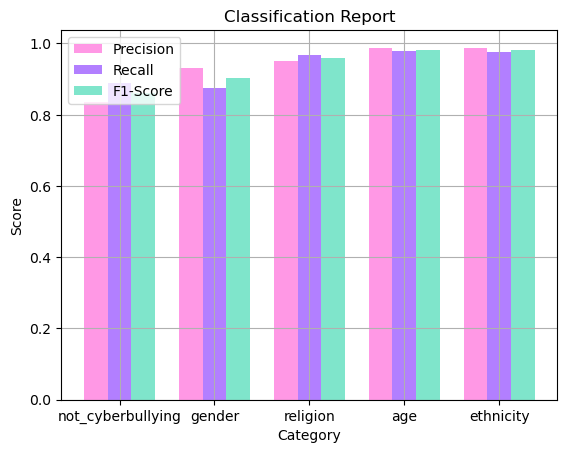

In [28]:
# Generate the classification report
report = classification_report(y_test, roberta_preds, target_names=possible_labels, output_dict=True)

# Extract categories for classification (excluding the overall metrics like 'accuracy', 'macro avg', 'weighted avg')
categories = [label for label in possible_labels if label in report]
print("Categories:", categories)

# Extracting precision, recall, and f1-score
precision = [report[category]['precision'] for category in categories]
recall = [report[category]['recall'] for category in categories]
f1_score = [report[category]['f1-score'] for category in categories]

# Setting the positions and width for the bars
pos = list(range(len(categories)))
width = 0.25 

# Plotting each metric
plt.bar(pos, precision, width, alpha=0.5, color='#ff33cc', label='Precision')
plt.bar([p + width for p in pos], recall, width, alpha=0.5, color='#6600ff', label='Recall')
plt.bar([p + width*2 for p in pos], f1_score, width, alpha=0.5, color='#00cc99', label='F1-Score')

# Adding the aesthetics
plt.xlabel('Category')
plt.ylabel('Score')
plt.title('Classification Report')

# Ensure the number of x-ticks matches the number of categories
plt.xticks([p + width for p in pos], categories)

# Adding the legend and showing the plot
plt.legend(['Precision', 'Recall', 'F1-Score'], loc='upper left')
plt.grid()
plt.show()
